https://naturalistic-data.org/content/timecorr.html  
https://github.com/ContextLab/timecorr  
https://timecorr.readthedocs.io/en/latest/api.html#timecorr  
https://timecorr.readthedocs.io/en/latest/tutorial/timecorr_notebook.html

In [1]:
import numpy as np
import os
import tensorflow as tf
import re
import timecorr as tc
from itertools import product
import scipy.stats
import pandas as pd
from nilearn import datasets
import matplotlib.pyplot as plt

2023-04-24 10:34:43.551255: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 10:34:43.614383: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 10:34:43.616403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 10:34:44.599458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline 
#so that matplotlib can display the graph directly

In [2]:
#function on Linux
def split_path_to_data(film, name_comparison="TC_14"):
    """Load data and separate it in 2
        return an array of all subject with their datapoints for all brain areas """
    file_name = os.listdir('data/'+film)
    all_path_to_14=[]
    all_path_to_400=[]
    for i in range(len(file_name)):
        path=(os.path.join('data/'+film, file_name[i]))
        condition=re.search(name_comparison,path)
        if (condition == None):
            all_path_to_400.append(path) 
        else:
            all_path_to_14.append(path)
    return all_path_to_14, all_path_to_400

def load_data_0(name_comparison="TC_14", film='Rest', TR=460): #mettre une taille définie par TR par film (faudra stocker une liste de film et de taille correspondante à un moment)
    path14, path400 = split_path_to_data(film, name_comparison=name_comparison)
    data_all_subjects=[]
    for n in range (len(path14)):
        data14=np.genfromtxt(path14[n], delimiter=",")
        data400=np.genfromtxt(path400[n], delimiter=",")
        data_one_subject=np.concatenate([data400[:TR], data14[:TR]], axis=1)
        data_all_subjects.append(data_one_subject)
    return data_all_subjects

def load_data(name_comparison="TC_14", film='Rest', TR=460, preprocess = True ): #mettre une taille définie par TR par film (faudra stocker une liste de film et de taille correspondante à un moment)
    path14, path400 = split_path_to_data(film, name_comparison=name_comparison)
    data_all_subjects=[]
    begin = 0
    end = TR
    if preprocess: 
        begin = 76
        end = (TR-76)
    for n in range (len(path14)):
        data14=np.genfromtxt(path14[n], delimiter=",")
        data400=np.genfromtxt(path400[n], delimiter=",")
        data_one_subject=np.concatenate([data400[begin:end], data14[begin:end]], axis=1)
        data_all_subjects.append(data_one_subject)
    return data_all_subjects

In [3]:
data=load_data(film='Sintel', TR=710)
data_Sintel=np.array(data)
data_Sintel.shape

(5, 558, 414)

In [13]:
# Definition of weights parameters
width = 30 #We choose 30 -> not too smooth (Ti (time interval) =1.3?)
#equivalent between 15 and 60s => equivalent TR
gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': width}}

In [14]:
def compute_timecorr(brain_regions):
    timecorr_br = tc.timecorr(brain_regions, weights_function=gaussian['weights'], weights_params=gaussian['params'])[:,2]
    timecorr_br = np.arctanh(timecorr_br)  # Fisher transform
    timecorr_br = scipy.stats.zscore(timecorr_br)  # Z-score
    return timecorr_br


In [15]:
AAC = ["7Networks_LH_SalVentAttn_Med_1", "7Networks_RH_SalVentAttn_Med_1"]
dlPFC = ["7Networks_LH_Cont_PFCl_5", "7Networks_RH_Cont_PFCl_9"]
insula = ["7Networks_LH_SomMot_4", "7Networks_RH_SomMot_6"]
amygdala = ["Left Amygdala", "Right Amygdala"]
hyppocampus = ["Left Hippocampus", "Right Hippocampus"]

#load cortical brain region names into a list
path_cort400_names = 'data/TC_cort400_labels.csv'
with open(path_cort400_names, encoding='utf-8-sig') as f:
    cort400_Name = np.genfromtxt(f, dtype=str, delimiter=',').tolist()

#load subcortical brain region names into a list
path_subcort14_name = 'data/TC_sub14_labels.csv'
with open(path_subcort14_name, encoding='utf-8-sig') as f:
    subcort14_Name = np.genfromtxt(f, dtype=str, delimiter=',').tolist()

cort_sub_414_name = cort400_Name + subcort14_Name

combination_amygdala_x_cort_sub = list(product(amygdala, cort_sub_414_name))
combination_hyppocampus_x_cort_sub = list(product(hyppocampus, cort_sub_414_name))
#attention dans la boucle for ça va pas aller pour deux fois dans cortical regions
combination_AAC_x_cort_sub = list(product(AAC, cort_sub_414_name))
combination_dlPFC_x_cort_sub = list(product(dlPFC, cort_sub_414_name))
combination_insula_x_cort_sub = list(product(insula, cort_sub_414_name))

Test for Amydgala x Cortical brain regions for 5 subject Sintel movie

In [21]:
Amygdala_x_cort = [r[0] + "_x_" + r[1] for r in combination_amygdala_x_cort_sub]

all_sb_dynamic_connectivity=[]
for sb in range (data_Sintel.shape[0]):
    dynamic_connectivity = {"fMRI": pd.DataFrame(columns=Amygdala_x_cort, index=range(0, 558))} #à mettre en paramètre quelque part = propore à chaque film
    for r in range (len(combination_amygdala_x_cort_sub)):
        #extract data points of pair of brain regions for subject sb
        index_subcort = 400 + subcort14_Name.index(combination_amygdala_x_cort_sub[r][0]) #brain regions from 400 to 414
        r_subcort = data_Sintel[sb,:,(index_subcort)]

        index_cort_sub=0
        if subcort14_Name.count(combination_amygdala_x_cort_sub[r][1])!=0:
            index_cort_sub = 400 + subcort14_Name.index(combination_amygdala_x_cort_sub[r][1])
        else : index_cort_sub = cort400_Name.index(combination_amygdala_x_cort_sub[r][1]) #brain regions from 0 to 400
        r_cort_sub = data_Sintel[sb,:,index_cort_sub]
        subcort_corSubcort = np.vstack((r_subcort, r_cort_sub)).transpose()
        #compute timecorr for one subject and a pair brain regions
        timecorr = compute_timecorr(subcort_corSubcort)

        #fill in the dataframe
        dynamic_connectivity['fMRI'][combination_amygdala_x_cort_sub[r][0] + '_x_' + combination_amygdala_x_cort_sub[r][1]] = timecorr
    all_sb_dynamic_connectivity.append(dynamic_connectivity)
    

Left Thalamus
Left Caudate
Left Putamen
Left Pallidum
Left Hippocampus
Left Amygdala
Left Accumbens
Right Thalamus
Right Caudate
Right Putamen
Right Pallidum
Right Hippocampus
Right Amygdala
Right Accumbens
Left Thalamus
Left Caudate
Left Putamen
Left Pallidum
Left Hippocampus
Left Amygdala
Left Accumbens
Right Thalamus
Right Caudate
Right Putamen
Right Pallidum
Right Hippocampus
Right Amygdala
Right Accumbens
Left Thalamus
Left Caudate
Left Putamen
Left Pallidum
Left Hippocampus
Left Amygdala
Left Accumbens
Right Thalamus
Right Caudate
Right Putamen
Right Pallidum
Right Hippocampus
Right Amygdala
Right Accumbens
Left Thalamus
Left Caudate
Left Putamen
Left Pallidum
Left Hippocampus
Left Amygdala
Left Accumbens
Right Thalamus
Right Caudate
Right Putamen
Right Pallidum
Right Hippocampus
Right Amygdala
Right Accumbens
Left Thalamus
Left Caudate
Left Putamen
Left Pallidum
Left Hippocampus
Left Amygdala
Left Accumbens
Right Thalamus
Right Caudate
Right Putamen
Right Pallidum
Right Hippocam

[{'fMRI':      Left Amygdala_x_7Networks_LH_Vis_1  Left Amygdala_x_7Networks_LH_Vis_2  \
  0                             -0.289599                           -0.129531   
  1                             -0.299475                           -0.116848   
  2                             -0.303891                           -0.100542   
  3                             -0.302256                           -0.083340   
  4                             -0.294632                           -0.068278   
  ..                                  ...                                 ...   
  553                           -0.026086                           -0.443053   
  554                           -0.024593                           -0.497994   
  555                           -0.045659                           -0.513810   
  556                           -0.075599                           -0.494384   
  557                           -0.104026                           -0.447550   
  
       Left Amygd

In [28]:
all_sb_dynamic_connectivity[0]['fMRI']#nan values for amygdala*amygdala

Left Amygdala_x_7Networks_LH_Vis_1  Left Amygdala_x_7Networks_LH_Vis_2  \
0                             -0.289599                           -0.129531   
1                             -0.299475                           -0.116848   
2                             -0.303891                           -0.100542   
3                             -0.302256                           -0.083340   
4                             -0.294632                           -0.068278   
..                                  ...                                 ...   
553                           -0.026086                           -0.443053   
554                           -0.024593                           -0.497994   
555                           -0.045659                           -0.513810   
556                           -0.075599                           -0.494384   
557                           -0.104026                           -0.447550   

     Left Amygdala_x_7Networks_LH_Vis_3  Left Amygdala_x_7Networks_LH_Vis_4  \
0                             -0.286754                           -0.338423   
1                             -0.283523                           -0.326982   
2                             -0.279595                           -0.308813   
3                             -0.276052                           -0.287030   
4                             -0.273873                           -0.265439   
..                                  ...                                 ...   
553                           -0.042342                            0.052996   
554                            0.067741                            0.138078   
555                            0.146791                            0.176195   
556                            0.185757                            0.172579   
557                            0.183925                            0.136989   

     Left Amygdala_x_7Networks_LH_Vis_5  Left Amygdala_x_7Networks_LH_Vis_6  \
0                             -0.384762                           -0.442746   
1                             -0.435660                           -0.439444   
2                             -0.487409                           -0.437725   
3                             -0.537207                           -0.439472   
4                             -0.582767                           -0.445817   
..                                  ...                                 ...   
553                           -0.008141                           -0.107976   
554                            0.132441                            0.068792   
555                            0.238210                            0.196625   
556                            0.296173                            0.260054   
557                            0.304037                            0.257070   

     Left Amygdala_x_7Networks_LH_Vis_7  Left Amygdala_x_7Networks_LH_Vis_8  \
0                             -0.552091                           -0.130054   
1                             -0.553761                           -0.135305   
2                             -0.540968                           -0.146031   
3                             -0.515542                           -0.163915   
4                             -0.480869                           -0.189332   
..                                  ...                                 ...   
553                           -0.446696                            0.152596   
554                           -0.554675                            0.264441   
555                           -0.648118                            0.333933   
556                           -0.709027                            0.356660   
557                           -0.729545                            0.337368   

     Left Amygdala_x_7Networks_LH_Vis_9  Left Amygdala_x_7Networks_LH_Vis_10  \
0                             -0.217680                            -0.266845   
1                             -0.226601          

all_sb_dynamic_connectivity is an array of len 5 which contains a dataframe of 710*800 where 710 = datapoints and 800 = all combination of left amygdala with 400 cortical regions followed by all combination of right amygdala with 400 cortical regions

In [30]:
# Save the array of dataframes to a file
with open('5_sub_Sintel_amygdala_cortical_subcortical_dyn_connectivity_width_30.pkl', 'wb') as f:
    pd.to_pickle(all_sb_dynamic_connectivity, f)
    f.close()

Functions useful in the notebook (add timecorr (see above))

In [60]:
#tested for subcortical = True not for = False ###ATTENTION NE FONCTIONNE PAS AVEC preprocess = True DANS LOAD DATA
def compute_dynamic_connectivity (combination_brain_regions, subcortical = True):
    rInterest_x_cort = [r[0] + "_x_" + r[1] for r in combination_brain_regions]
    all_sb_dynamic_connectivity=[]
    for sb in range (data_Sintel.shape[0]):
        dynamic_connectivity = {"fMRI": pd.DataFrame(columns=rInterest_x_cort, index=range(0, 710))}
        for r in range (len(combination_brain_regions)):
            #extract data points of pair of brain regions for subject sb
            index_rInterest = 0
            if subcortical : index_rInterest = 400 + subcort14_Name.index(combination_brain_regions[r][0])
            else : index_rInterest = cort400_Name.index(combination_brain_regions[r][0])
            index_cort = cort400_Name.index(combination_brain_regions[r][1]) 
            
            #extract timeseries for the corresponding brain regions
            rInterest = data_Sintel[sb,:,(index_rInterest)]
            r_cort = data_Sintel[sb,:,index_cort]
            sb_cor_subcort = np.vstack((rInterest, r_cort)).transpose()
            
            #compute timecorr for one subject and a pair brain regions
            timecorr = compute_timecorr(sb_cor_subcort)

            #fill in the dataframe
            dynamic_connectivity['fMRI'][combination_brain_regions[r][0] + '_x_' + combination_brain_regions[r][1]] = timecorr
        all_sb_dynamic_connectivity.append(dynamic_connectivity)
    return all_sb_dynamic_connectivity

Plot for different time window!

Width = 10

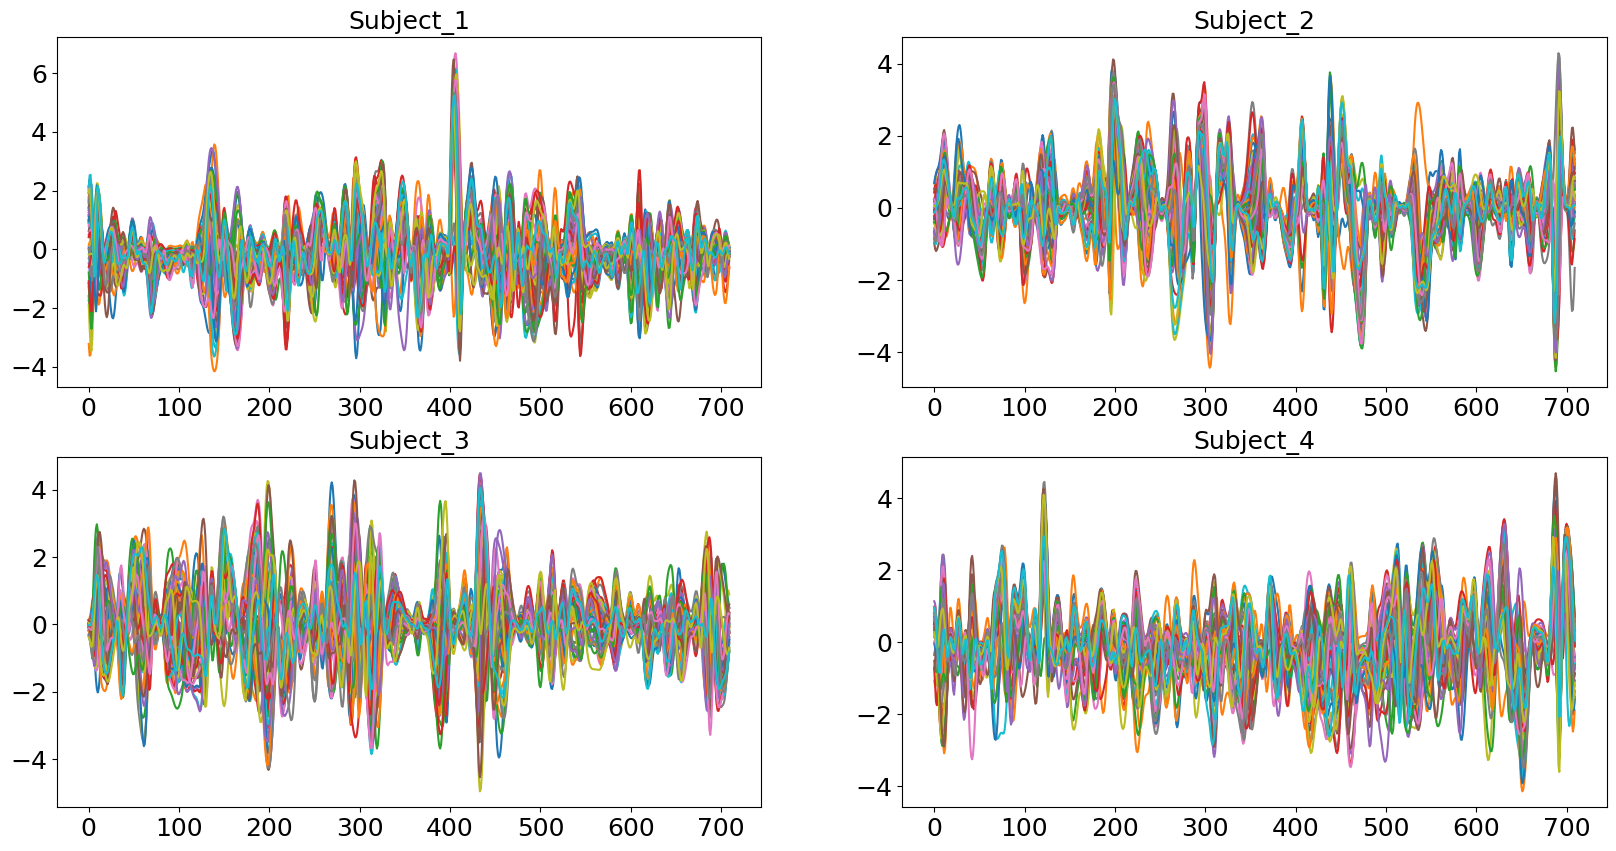

In [63]:
# Create the figure and the subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

timepoints = np.arange(0, 710, 1)
inf = 100
sup = 150
# Plot data on the different subplots
axs[0][0].plot(timepoints, np.array(all_sb_dynamic_connectivity[0]['fMRI'].iloc[:, inf:sup]))
axs[0][0].set_title('Subject_1')

axs[0][1].plot(timepoints, np.array(all_sb_dynamic_connectivity[1]['fMRI'].iloc[:, inf:sup]))
axs[0][1].set_title('Subject_2')

axs[1][0].plot(timepoints, np.array(all_sb_dynamic_connectivity[2]['fMRI'].iloc[:, inf:sup]))
axs[1][0].set_title('Subject_3')

axs[1][1].plot(timepoints, np.array(all_sb_dynamic_connectivity[3]['fMRI'].iloc[:, inf:sup]))
axs[1][1].set_title('Subject_4')

plt.show()

Plot for different width = 20, 30, 40, 50

Beginning connectivity computation
End connectivity computation
Beginning plotting


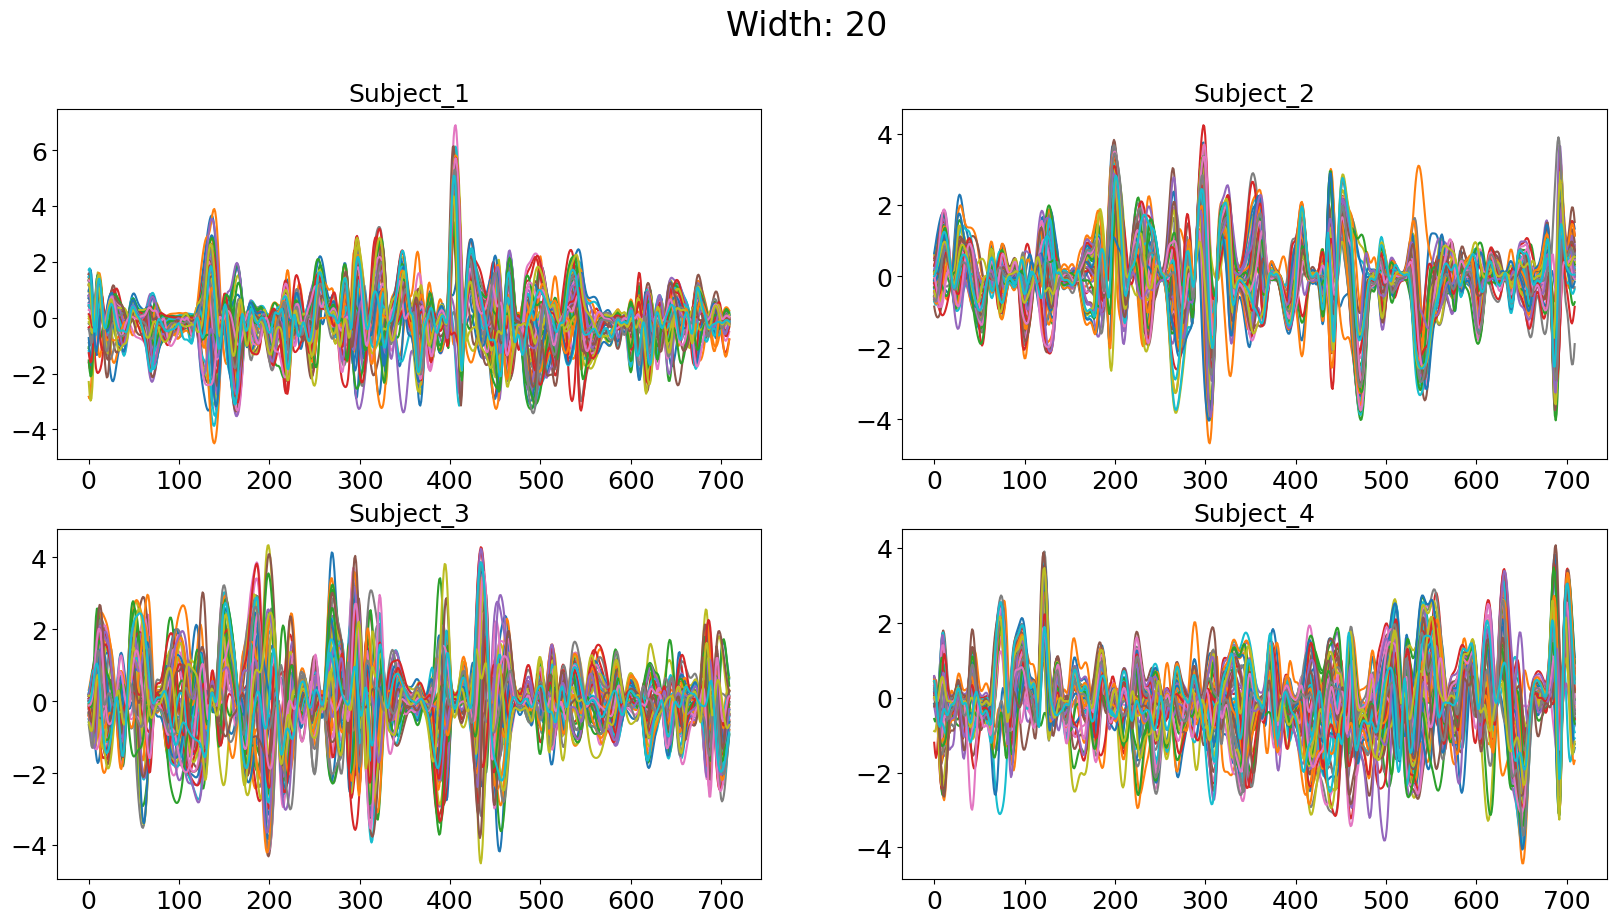

End plotting
Beginning connectivity computation
End connectivity computation
Beginning plotting


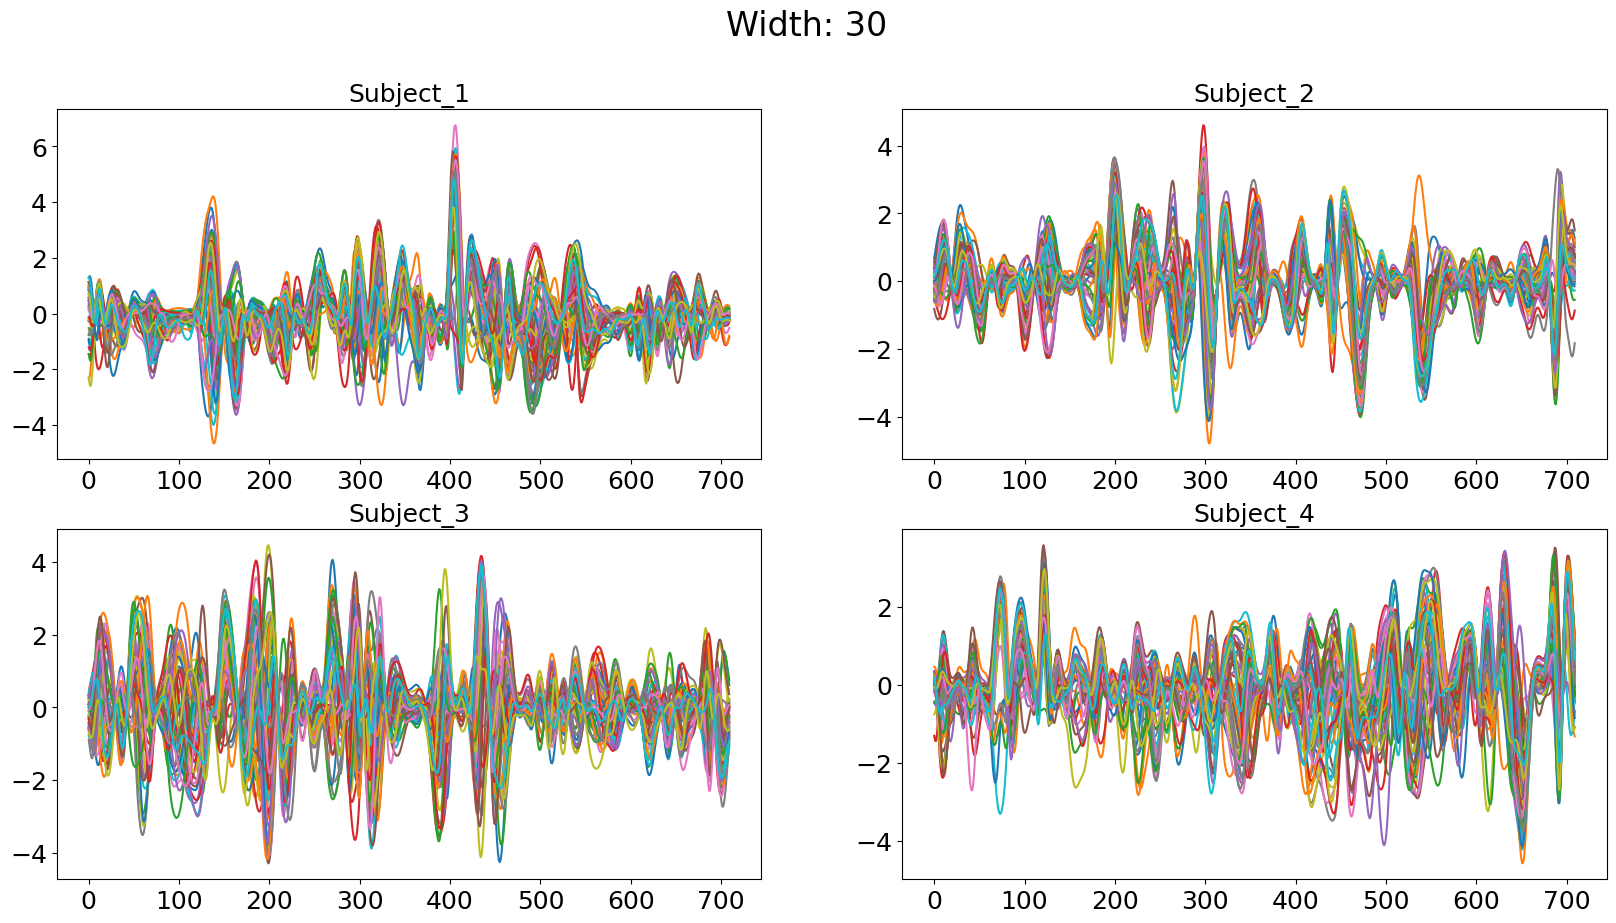

End plotting


In [65]:
width = [20, 30]
connectivity_widths = []
for w in width:
    gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': w}}
    print('Beginning connectivity computation')
    connectivity = compute_dynamic_connectivity(combination_amygdala_cort)
    connectivity_widths.append(connectivity)
    print('End connectivity computation')

    print('Beginning plotting')
    # Create the figure and the subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    timepoints = np.arange(0, 710, 1)
    inf = 100
    sup = 150
    # Plot data on the different subplots
    axs[0][0].plot(timepoints, np.array(connectivity[0]['fMRI'].iloc[:, inf:sup]))
    axs[0][0].set_title('Subject_1')

    axs[0][1].plot(timepoints, np.array(connectivity[1]['fMRI'].iloc[:, inf:sup]))
    axs[0][1].set_title('Subject_2')

    axs[1][0].plot(timepoints, np.array(connectivity[2]['fMRI'].iloc[:, inf:sup]))
    axs[1][0].set_title('Subject_3')

    axs[1][1].plot(timepoints, np.array(connectivity[3]['fMRI'].iloc[:, inf:sup]))
    axs[1][1].set_title('Subject_4')

    fig.suptitle(f'Width: {w}')
    plt.show()
    print ('End plotting')

Beginning connectivity computation
End connectivity computation
Beginning plotting


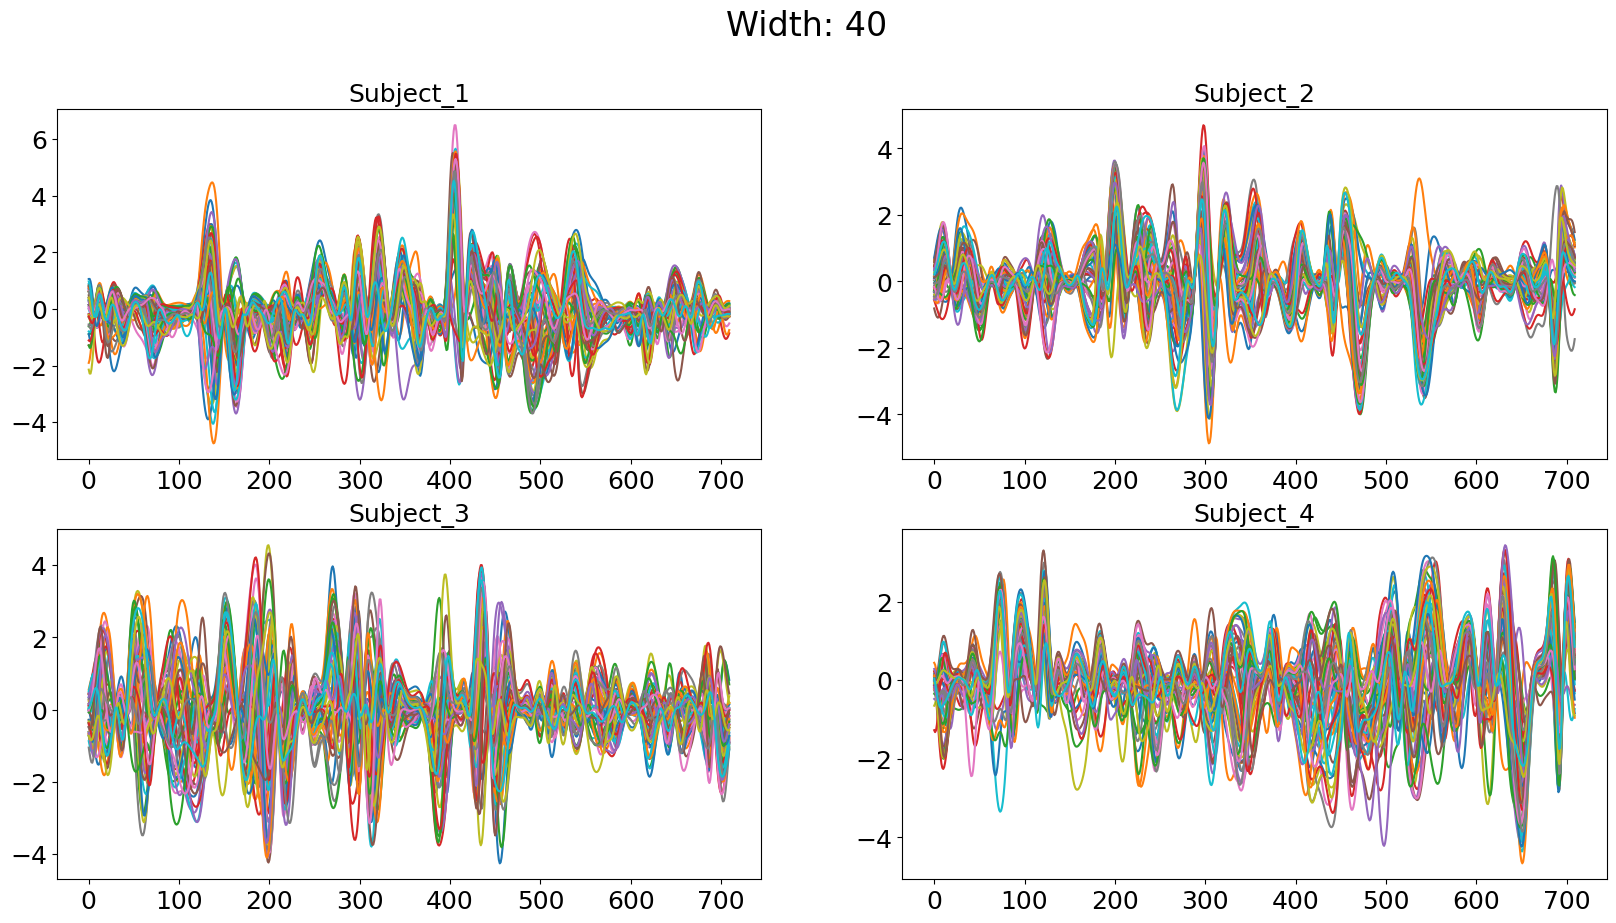

End plotting
Beginning connectivity computation
End connectivity computation
Beginning plotting


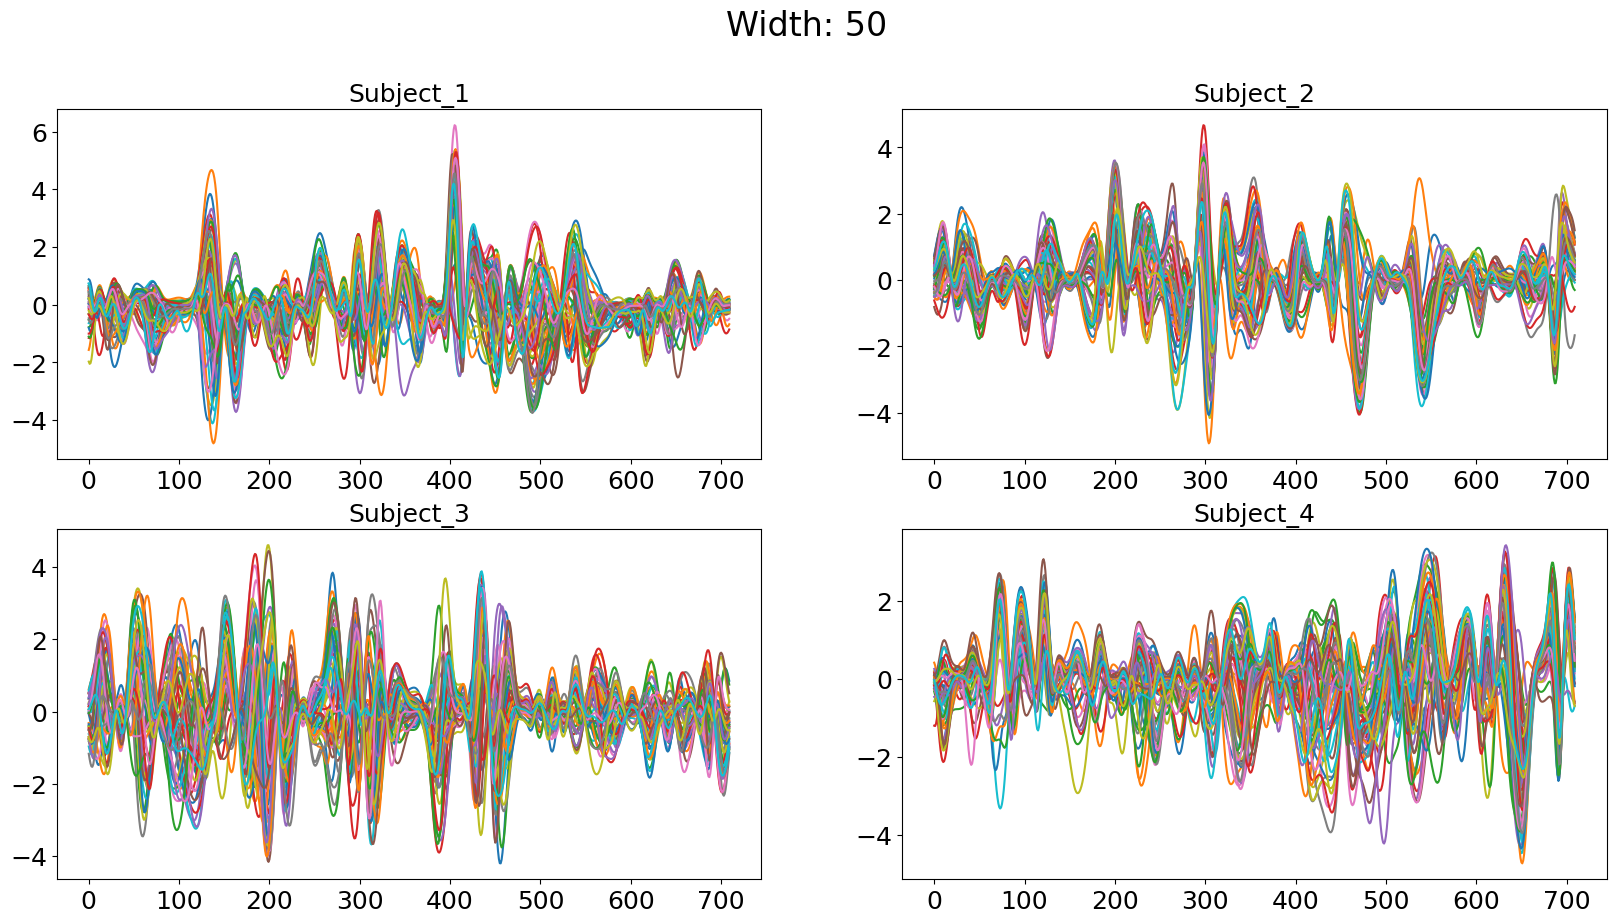

End plotting


In [66]:
width = [40, 50]
connectivity_widths = []
for w in width:
    gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': w}}
    print('Beginning connectivity computation')
    connectivity = compute_dynamic_connectivity(combination_amygdala_cort)
    connectivity_widths.append(connectivity)
    print('End connectivity computation')

    print('Beginning plotting')
    # Create the figure and the subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    timepoints = np.arange(0, 710, 1)
    inf = 100
    sup = 150
    # Plot data on the different subplots
    axs[0][0].plot(timepoints, np.array(connectivity[0]['fMRI'].iloc[:, inf:sup]))
    axs[0][0].set_title('Subject_1')

    axs[0][1].plot(timepoints, np.array(connectivity[1]['fMRI'].iloc[:, inf:sup]))
    axs[0][1].set_title('Subject_2')

    axs[1][0].plot(timepoints, np.array(connectivity[2]['fMRI'].iloc[:, inf:sup]))
    axs[1][0].set_title('Subject_3')

    axs[1][1].plot(timepoints, np.array(connectivity[3]['fMRI'].iloc[:, inf:sup]))
    axs[1][1].set_title('Subject_4')

    fig.suptitle(f'Width: {w}')
    plt.show()
    print ('End plotting')

Beginning connectivity computation
End connectivity computation
Beginning plotting


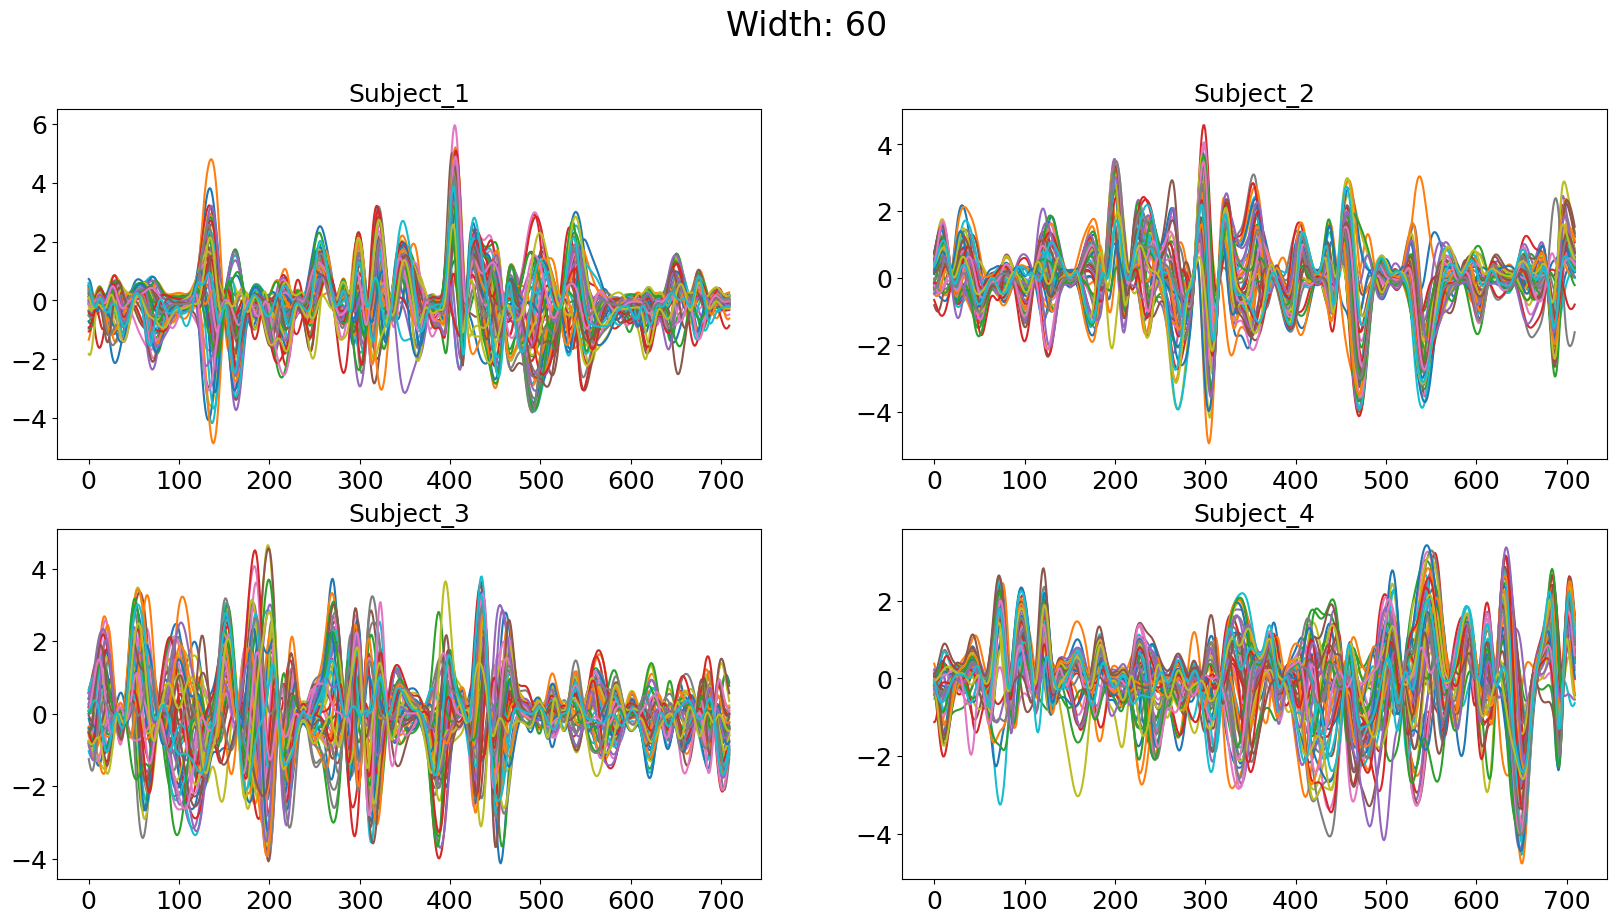

End plotting
Beginning connectivity computation
End connectivity computation
Beginning plotting


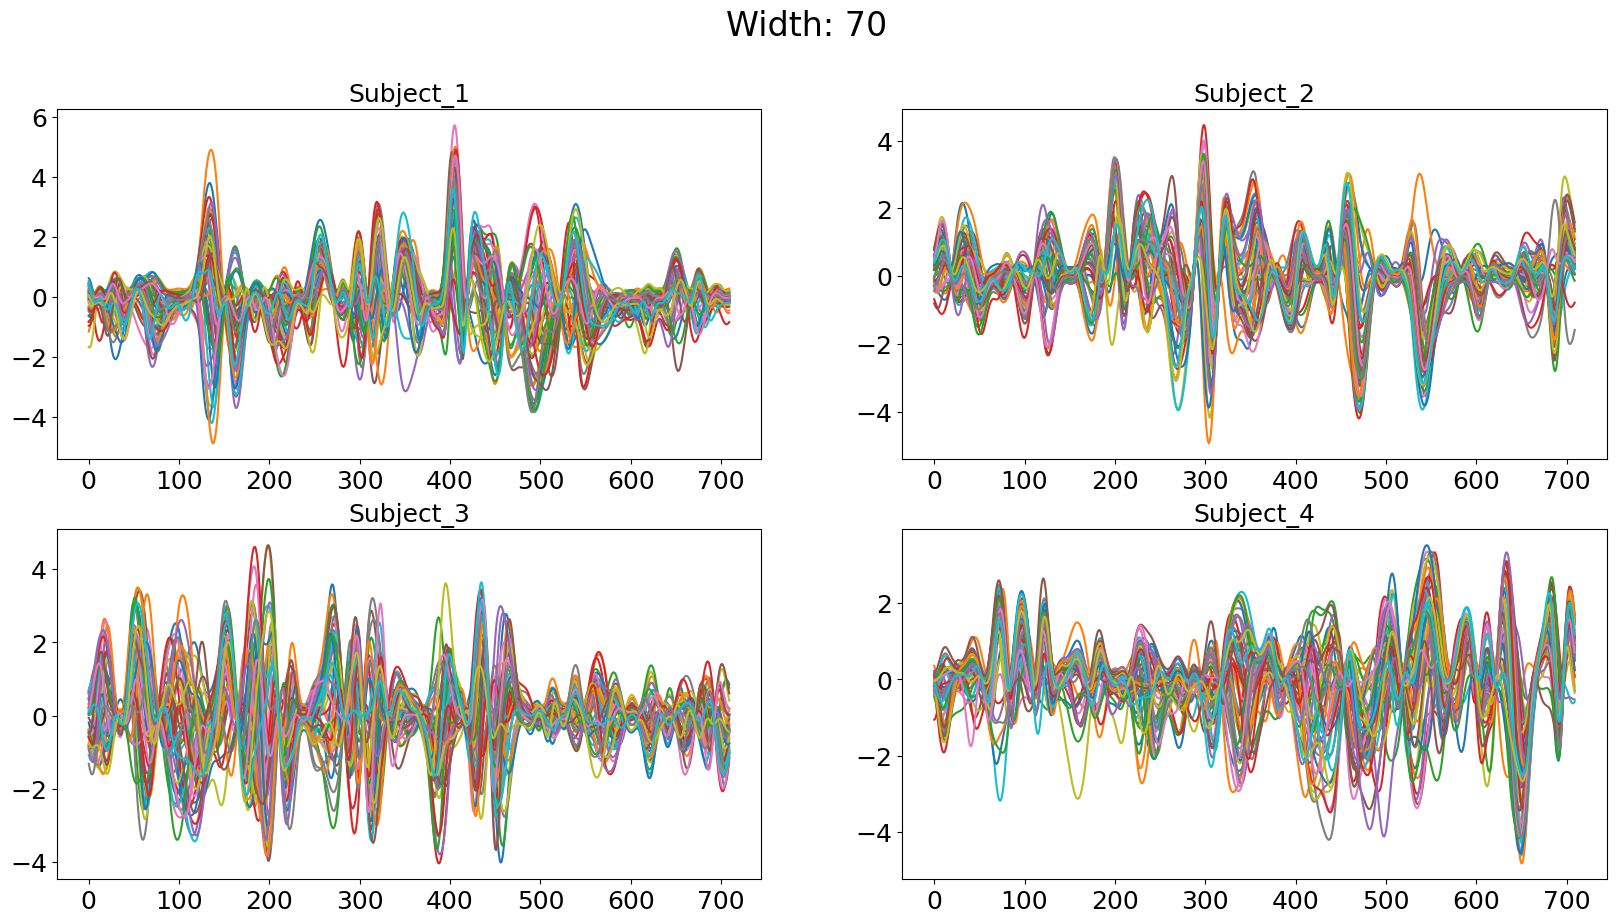

End plotting
Beginning connectivity computation


KeyboardInterrupt: 

In [67]:
width = [60, 70, 80, 90, 100]
connectivity_widths = []
for w in width:
    gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': w}}
    print('Beginning connectivity computation')
    connectivity = compute_dynamic_connectivity(combination_amygdala_cort)
    connectivity_widths.append(connectivity)
    print('End connectivity computation')

    print('Beginning plotting')
    # Create the figure and the subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    timepoints = np.arange(0, 710, 1)
    inf = 100
    sup = 150
    # Plot data on the different subplots
    axs[0][0].plot(timepoints, np.array(connectivity[0]['fMRI'].iloc[:, inf:sup]))
    axs[0][0].set_title('Subject_1')

    axs[0][1].plot(timepoints, np.array(connectivity[1]['fMRI'].iloc[:, inf:sup]))
    axs[0][1].set_title('Subject_2')

    axs[1][0].plot(timepoints, np.array(connectivity[2]['fMRI'].iloc[:, inf:sup]))
    axs[1][0].set_title('Subject_3')

    axs[1][1].plot(timepoints, np.array(connectivity[3]['fMRI'].iloc[:, inf:sup]))
    axs[1][1].set_title('Subject_4')

    fig.suptitle(f'Width: {w}')
    plt.show()
    print ('End plotting')